In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import re 
import nltk

from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from nltk import sent_tokenize,word_tokenize
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score,make_scorer

from time import time
import pickle


In [4]:
df=pd.read_csv("dataset.csv")

In [5]:
df.head()

,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [6]:
df['label'].unique()

array([-1,  0])

In [7]:
df.index

RangeIndex(start=0, stop=18148, step=1)

DATAFRAME MANIPULATION 

In [9]:
def perform_data_manipulation():
    df= pd.read_csv("dataset.csv")
    for i in df.index:
        if df.loc[i,"label"]==-1:
            df.loc[i,"label"]=1

    return df

In [10]:
df=perform_data_manipulation()

In [11]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [12]:
# now only 1 and 0
df["label"].unique()

array([1, 0])

In [13]:
#number of rows
df.shape[0]

18148

In [14]:
def data_distribution(df):
    total=df["label"].shape[0]
    num_non_toxic=df[df["label"]==0].shape[0]
    num_toxic=df[df["label"]==1].shape[1]
    slices=[num_non_toxic/total,(total-num_non_toxic)/total]
    n_rows=df.shape[0]
    label=["NON-TOXIC","TOXIC"]
    plt.pie(slices,explode=[0.2,0],labels=label,autopct="%1.1f%%",shadow=True,wedgeprops={'edgecolor': 'black'})
    plt.title("TOXIC VS NON-TOXIC TEST SAMPLE")
    plt.tight_layout()
    plt.show()

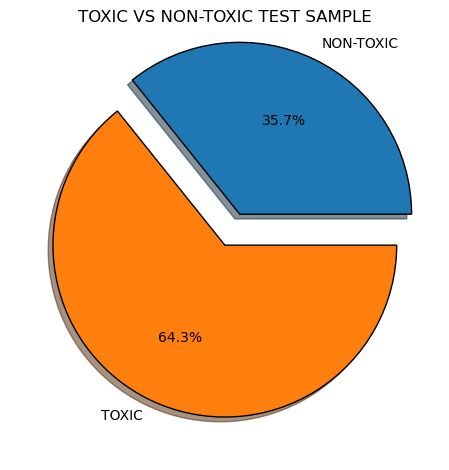

In [15]:
data_distribution(df)

In [17]:
def remove_pattern(input_text,pattern):
    if (type(input_text)==str):
        r=re.findall(pattern,input_text)
        for i in r:
            input_text=re.sub(i,' ',input_text)
        return input_text
    else:
        return ''
        

In [23]:
df.head(5)

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [24]:
def datasetCleaning(df):
    df["headline length"]=df["headline"].str.len()
    combined_df=pd.concat([df,df],ignore_index=True)
    #remove @
    combined_df['tidy_tweet']=combined_df['headline'].apply(lambda text:remove_pattern(text,"@[\w]*"))
                                                            
    #remove extra letters
    combined_df['tidy_tweet']=combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")  
    
    #remove all those words having lenght more than 3
    combined_df['tidy_tweet']=combined_df['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
    combined_df['length_tidy_tweet']=combined_df['tidy_tweet'].str.len()

    #tokenisation 
    tokenized_tweet=combined_df['tidy_tweet'].apply(lambda x:x.split())
    nltk.download('wordnet')
    lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()  #shortens the word to its shortest lemma(base of a word) from the wordnet_corpus(datbase)
    tokenized_tweet=tokenized_tweet.apply(lambda x:[lemmatizer.lemmatize(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet']=tokenized_tweet

    return combined_df,df

    
    

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1m/wdqr01dx2l14dyqfbkfryt7w0000gn/T/ipykernel_1041/1097293623.py:5: SyntaxWarning: invalid escape sequence '\w'
  combined_df['tidy_tweet']=combined_df['headline'].apply(lambda text:remove_pattern(text,"@[\w]*"))


In [25]:
combined_df,df=datasetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mukunddixit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
combined_df.head(5)

,headline,label,headline length,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


In [32]:
from sklearn.model_selection import train_test_split

In [37]:
#TRAIN_TEST_SPLIT
def performDataSplit(x,y,combined_df,df):
    X_train,X_test,y_train,y_test=train_test_split(combined_df['tidy_tweet'],combined_df['label'],test_size=x,random_state=y)
    print(f"number of rows in the total dataset{combined_df.shape[0]}")
    print(f"number of rows in the train dataset{X_train.shape[0]}")
    print(f"number of rows in the test dataset{X_test.shape[0]}")

    files=open("stopwords.txt","r")
    content=files.read()
    content_list=content.split("\n")
    files.close()

    tfid_vector=TfidfVectorizer(stop_words=content_list,lowercase=True)
    training_data=tfid_vector.fit_transform(X_train.values.astype('U'))#converts the values of the trainig dataset into unicode form
    testing_data=tfid_vector.transform(X_test.values.astype('U'))#converts the values of the testing dataset into unicode form

    filename='tfidfvectoizer.pkl'

    pickle.dump(tfid_vector.vocabulary_,open(filename,"wb")) #tfid_vaocbulary stores the dict of word with values as indexes

    return X_train,X_test,y_train,y_test,testing_data,training_data,filename,content_list
    

In [38]:
X_train,X_test,y_train,y_test,testing_data,training_data,filename,content_list=performDataSplit(0.2,42,combined_df,df)

number of rows in the total dataset36296
number of rows in the train dataset29036
number of rows in the test dataset7260


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


In [39]:
import xgboost as xgb

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [41]:
def Pipeline(X_train,X_test,y_train,y_test):
    MODELS=[LinearSVC(),MultinomialNB(),DecisionTreeClassifier(),GradientBoostingClassifier(),
            BaggingClassifier(),xgb.XGBClassifier(),LogisticRegression(),
            KNeighborsClassifier(),AdaBoostClassifier(),]
    size=len(y_train)
    results={}
    final_result=[]

    for model in MODELS:
        results['Algorithm']=model.__class__.__name__

        start=time()
        print(f"Training time of {model.__class__.__name__}:")
        model.fit(X_train,y_train)
        end=time()

        filename=model.__class__.__name__+".pkl"
        pickle.dump(model,open(filename,"wb"))

        results['training_time']=end-start

        start=time()
        train_pred=model.predict(X_train)
        test_pred=model.predict(X_test)
        end=time()

        results['prediction_time']=end-start

        results['Accuracy:Train']= accuracy_score(y_train,train_pred)
        results['Accuracy:Test']= accuracy_score(y_test,test_pred)

        results['Precision:Train']= precision_score(y_train,train_pred)
        results['Precision:Test']= precision_score(y_train,train_pred)

        results['F-1 score:Train']= f1_score(y_train,train_pred)
        results['F-1 score:Test']= f1_score(y_train,train_pred)

        results['Recall:Train']= recall_score(y_train,train_pred)
        results['Recall:Test']= recall_score(y_train,train_pred)

        print(f"the training of {model.__class__.__name__} model was finished in {results['training_time']} seconds")

        final_result.append(results.copy()) # use copy so that changes in results does not affect final_result

    return final_result
        
        
        
        

In [42]:
final_result=Pipeline(training_data,testing_data,y_train,y_test)

Training time of LinearSVC:
the training of LinearSVC model was finished in 0.05252408981323242 seconds
Training time of MultinomialNB:
the training of MultinomialNB model was finished in 0.003883838653564453 seconds
Training time of DecisionTreeClassifier:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


the training of DecisionTreeClassifier model was finished in 2.2548627853393555 seconds
Training time of GradientBoostingClassifier:
the training of GradientBoostingClassifier model was finished in 6.725405931472778 seconds
Training time of BaggingClassifier:
the training of BaggingClassifier model was finished in 15.540657043457031 seconds
Training time of XGBClassifier:
the training of XGBClassifier model was finished in 2.417923927307129 seconds
Training time of LogisticRegression:
the training of LogisticRegression model was finished in 0.24526381492614746 seconds
Training time of KNeighborsClassifier:
the training of KNeighborsClassifier model was finished in 0.0013129711151123047 seconds
Training time of AdaBoostClassifier:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


the training of AdaBoostClassifier model was finished in 1.8210420608520508 seconds


In [43]:
def performFinalResult(final_result):
    results=pd.DataFrame(final_result)
    results.reindex(columns=['Algorithm', 'Accuracy:Test', 'Precision:Test', 'Recall:Test', 'F-1 score:Test', 'prediction_time',
                          'Accuracy:Train', 'Precision:Train', 'Recall:Train', 'F-1 score:Train', 'training_time'])
    results.sort_values(by='F-1 score:Test',inplace=True ,ascending=False)

    return results

In [44]:
results=performFinalResult(final_result)

In [45]:
results=results.reset_index(drop=True)

In [46]:
results

,Algorithm,training_time,prediction_time,Accuracy:Train,Accuracy:Test,Precision:Train,Precision:Test,F-1 score:Train,F-1 score:Test,Recall:Train,Recall:Test
0,DecisionTreeClassifier,2.254863,0.021403,0.996832,0.974656,0.996146,0.996146,0.997534,0.997534,0.998926,0.998926
1,BaggingClassifier,15.540657,0.228183,0.994765,0.968320,0.995176,0.995176,0.995923,0.995923,0.996672,0.996672
2,LinearSVC,0.052524,0.001302,0.989048,0.964463,0.992152,0.992152,0.991459,0.991459,0.990767,0.990767
3,LogisticRegression,0.245264,0.000956,0.961737,0.937328,0.972489,0.972489,0.970108,0.970108,0.967738,0.967738
4,MultinomialNB,0.003884,0.002413,0.927676,0.899174,0.916159,0.916159,0.945438,0.945438,0.976649,0.976649
5,XGBClassifier,2.417924,0.032780,0.909216,0.895317,0.979263,0.979263,0.925355,0.925355,0.877073,0.877073
6,KNeighborsClassifier,0.001313,12.370451,0.876360,0.760606,0.880561,0.880561,0.906481,0.906481,0.933974,0.933974
7,GradientBoostingClassifier,6.725406,0.033572,0.837994,0.841322,0.816607,0.816607,0.884195,0.884195,0.963981,0.963981
8,AdaBoostClassifier,1.821042,0.498278,0.841955,0.840909,0.969063,0.969063,0.863402,0.863402,0.778517,0.778517


In [60]:
results.describe().loc[['max','min'],:]

,training_time,prediction_time,Accuracy:Train,Accuracy:Test,Precision:Train,Precision:Test,F-1 score:Train,F-1 score:Test,Recall:Train,Recall:Test
max,15.540657,12.370451,0.996832,0.974656,0.996146,0.996146,0.997534,0.997534,0.998926,0.998926
min,0.001313,0.000956,0.837994,0.760606,0.816607,0.816607,0.863402,0.863402,0.778517,0.778517


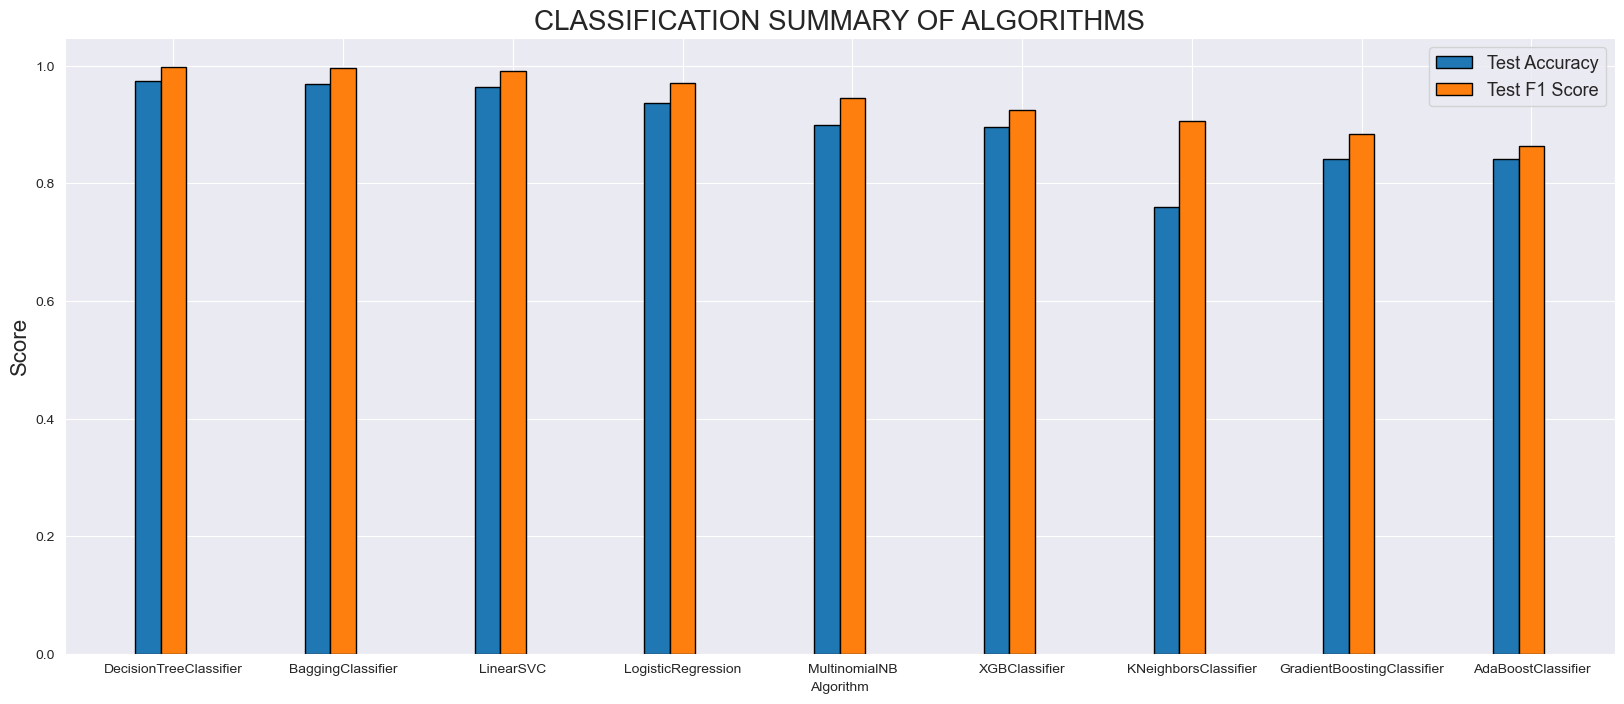

In [109]:
best_acc = results[results['Accuracy:Test'] == results['Accuracy:Test'].max()]
best_f1 = results[results['F-1 score:Test'] == results['F-1 score:Test'].max()]
best_precision = results[results['Precision:Test'] == results['Precision:Test'].max()]
best_recall = results[results['Recall:Test'] == results['Recall:Test'].max()]

sns.set_style("darkgrid")
plt.figure(figsize=(20,8))

barwidth=0.15

#set height of the bars
bar1=results['Accuracy:Test']
bar2=results['F-1 score:Test']

#positions of bars on the axis (spacing)
r1=np.arange(len(bar1))
r2=[x+barwidth for x in r1]

#Make the plot
pal = sns.color_palette()
plt.bar(r1, bar1, color= pal[0], width=barwidth, edgecolor='black', label='Test Accuracy')
plt.bar(r2, bar2, color= pal[1], width=barwidth, edgecolor='black', label='Test F1 Score')

plt.xlabel('Algorithm')
plt.ylabel('Score',fontsize=16)
plt.xticks([r + barwidth for r in range(len(bar1))], results['Algorithm'])
plt.title("CLASSIFICATION SUMMARY OF ALGORITHMS",fontsize=20)
plt.legend(fontsize = 13)
plt.show()


In [120]:
plt.style.use("ggplot")

## TRAINING AND PREDICTION TIME OF ALGORITHMS

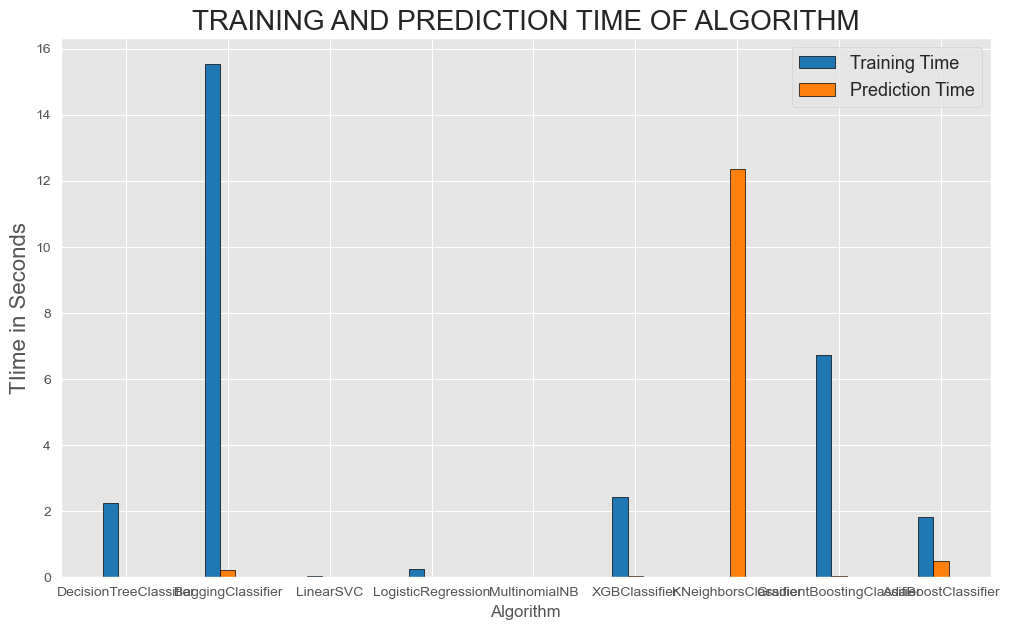

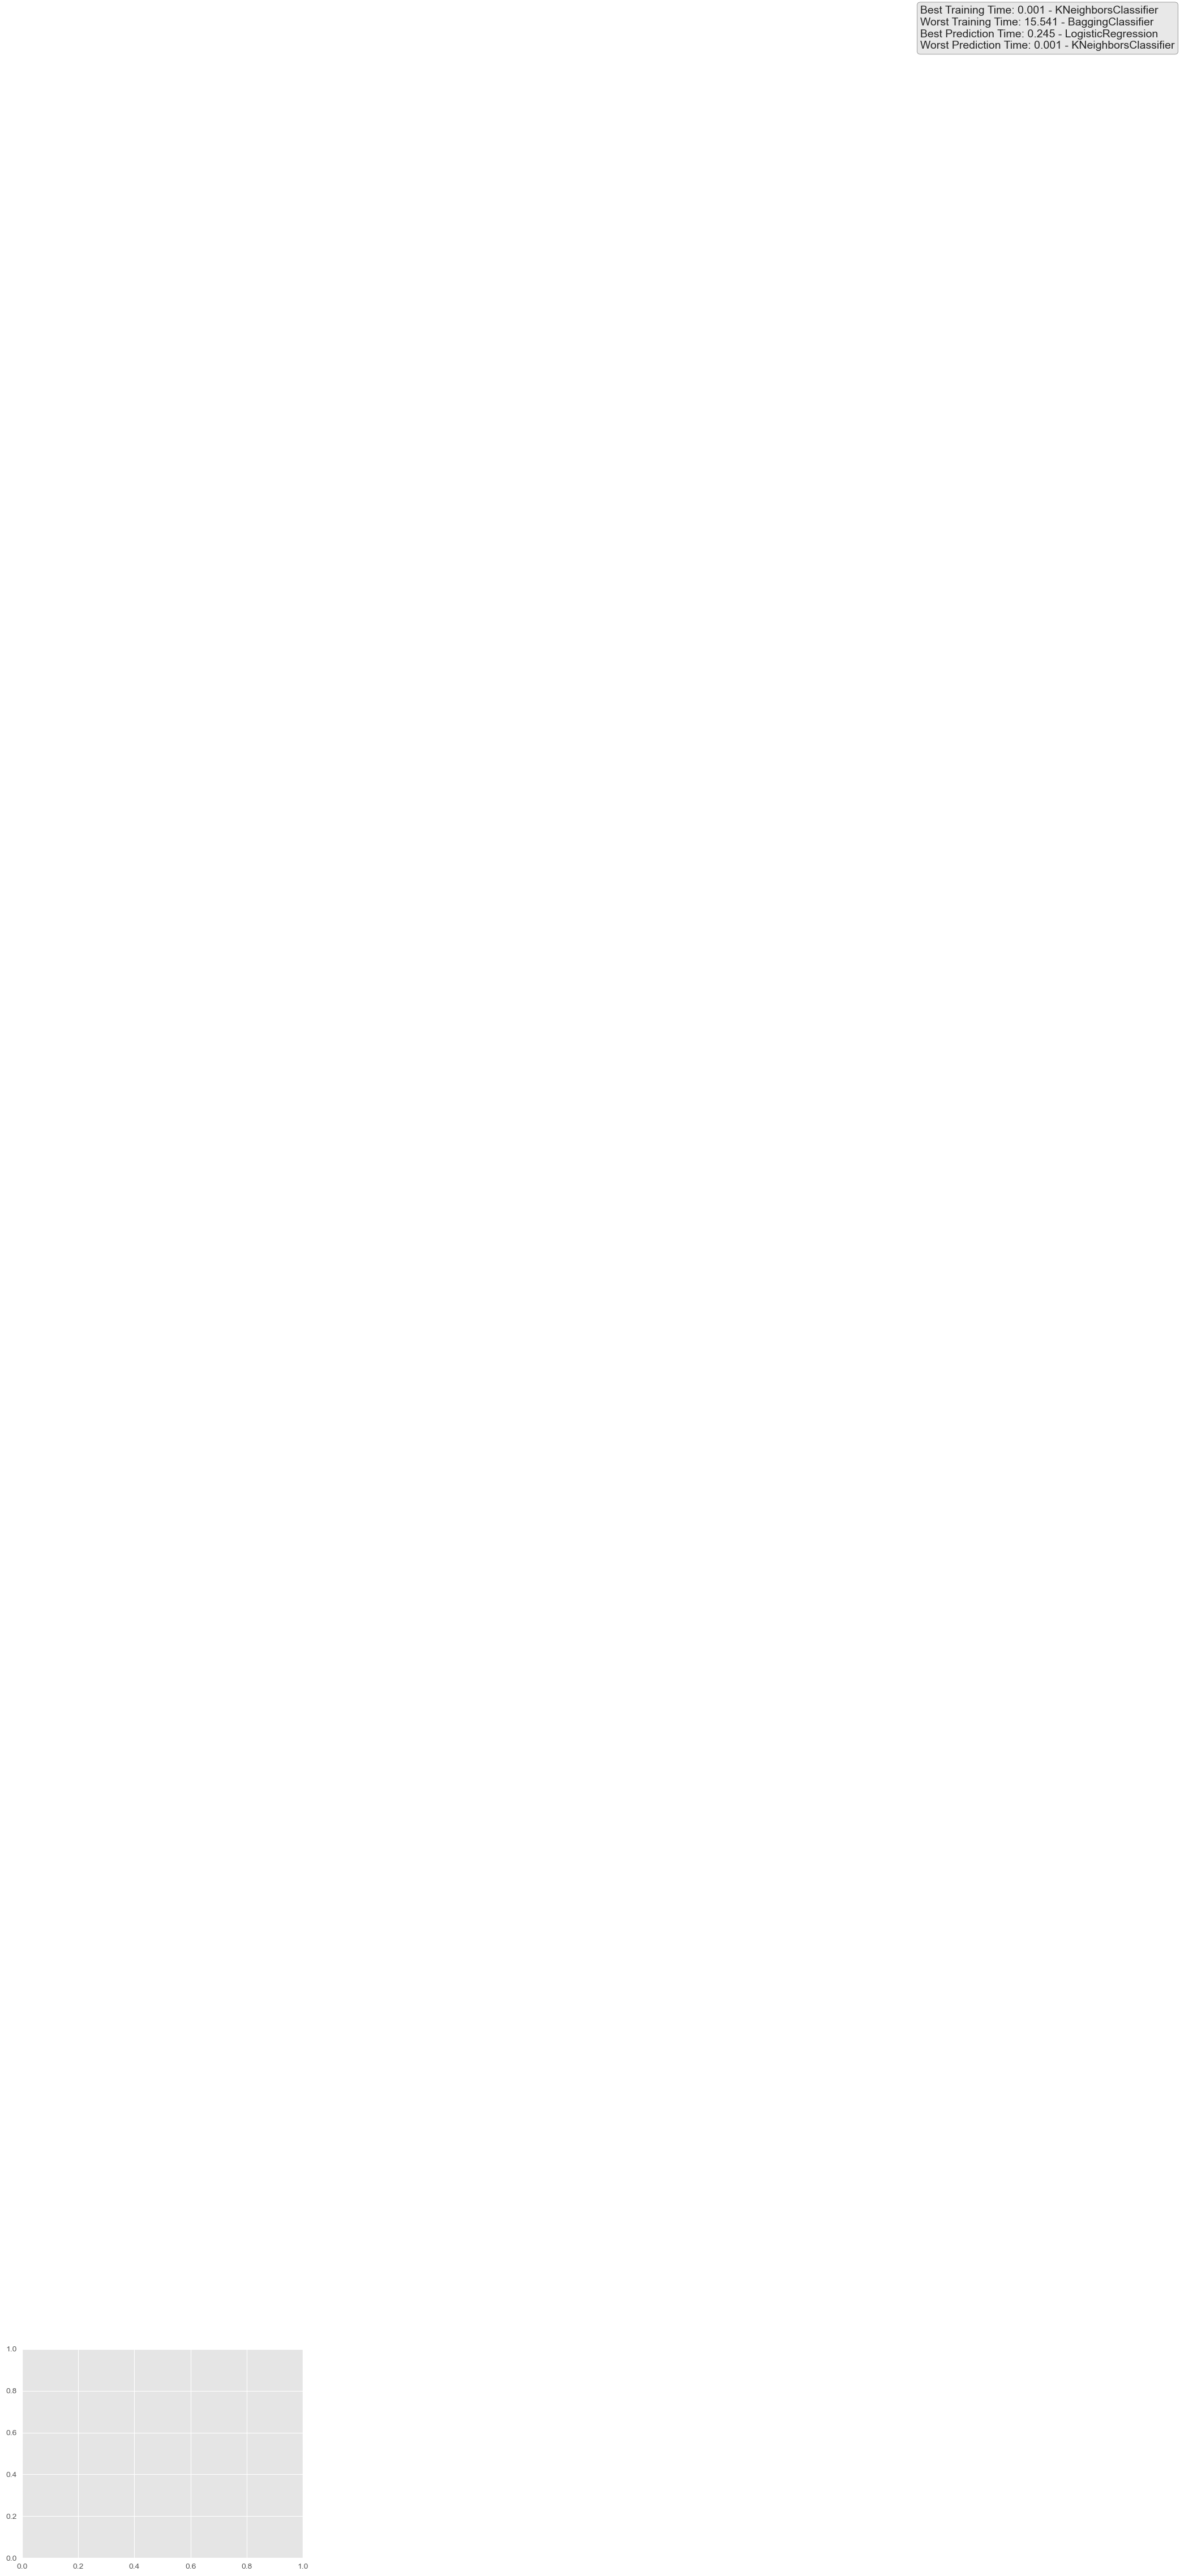

In [143]:
best_training_time = results[results['training_time'] == results['training_time'].min()]
worst_train_time = results[results['training_time'] == results['training_time'].max()]
best_prediction_time = results[results['prediction_time'] == results['prediction_time'].min()]
worst_prediction_time = results[results['prediction_time'] == results['prediction_time'].max()]


plt.figure(figsize=(12,7))

barwidth=0.15

#set height of the bars
bar1=results['training_time']
bar2=results['prediction_time']

#positions of bars on the axis (spacing)
r1=np.arange(len(bar1))
r2=[x+barwidth for x in r1]

# Make the plot
plt.bar(r1, bar1, color= pal[0], width=barwidth, edgecolor='black', label='Training Time')
plt.bar(r2, bar2, color= pal[1], width=barwidth, edgecolor='black', label='Prediction Time')
 
plt.xlabel('Algorithm')
plt.ylabel('TIime in Seconds',fontsize=16)
plt.xticks([r + barwidth for r in range(len(bar1))], results['Algorithm'])
plt.title("TRAINING AND PREDICTION TIME OF ALGORITHM",fontsize=20)
plt.legend(fontsize = 13)
plt.show()

# Create the text string
textstr = '\n'.join([
    f"Best Training Time: {best_training_time['training_time'].values[0]:.3f} - {best_training_time['Algorithm'].values[0]}",
    f"Worst Training Time: {worst_train_time['training_time'].values[0]:.3f} - {worst_train_time['Algorithm'].values[0]}",
    f"Best Prediction Time: {best_prediction_time['training_time'].values[0]:.3f} - {best_prediction_time['Algorithm'].values[0]}",
    f"Worst Prediction Time: {worst_prediction_time['training_time'].values[0]:.3f} - {worst_prediction_time['Algorithm'].values[0]}"
])

# Text box properties
props = dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.5)

# Place the text box
plt.text(
    3.2, 12,         # Coordinates to place the text box
    textstr,         # Text content
    fontsize=14,     # Font size
    bbox=props       # Text box styling
)
plt.show()


In [145]:
df.head()

,headline,label,headline length
0,cock suck before you piss around on my work,1,44
1,you are gay or antisemmitian archangel white ...,1,624
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [157]:
data=["you are so beautifull"]

tfid_vector=TfidfVectorizer(stop_words=content_list,lowercase=True,vocabulary=pickle.load(open("tfidfvectoizer.pkl","rb")))
preprocessed_data=tfid_vector.fit_transform(data)

trained_model=pickle.load(open("LinearSVC.pkl","rb"))
print(trained_model.predict(preprocessed_data))

if trained_model.predict(preprocessed_data)==1:
    print("bullying")
else:
    print("non-bullying")

[0]
non-bullying


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


### FINE TUNING 

In [162]:
from sklearn.model_selection import GridSearchCV
def tuning(clf,param_dict,X_train,y_train,X_test,y_test):
    scorer=make_scorer(f1_score)
    grid=GridSearchCV(estimator=clf,param_grid=param_dict,scoring=scorer,cv=3)
    grid_fit=grid.fit(X_train,y_train)
    best_clf=grid_fit.best_estimator_

    prediction=(clf.fit(X_train,y_train).predict(X_test))
    best_prediction=best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")
    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    print(f"Recall:  {recall_score(y_test, best_prediction)}")


In [164]:
param_grid={
    "C":[0.25,0.5,0.75,1,1.2]
}

clf_model=LinearSVC()
tuning(clf_model,param_grid,training_data,y_train,testing_data,y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/

LinearSVC
Best Parameter:  {'C': 1}
Accuracy:  0.9644628099173553
F1 Score :  0.9724829351535836
Precision :  0.9735212470638479
Recall:  0.9714468357127637


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
pickle.dump(clf_model,open("LinearSVCTuned.pkl","wb")